In [1]:
import numpy as np
import pandas as pd
import json
from math import sqrt
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_white
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from math import sqrt
from sklearn.metrics import mean_squared_error
from scipy.stats import ttest_1samp

In [2]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', UserWarning)

In [3]:
with open('config.json') as f:
    config = json.load(f)

data_path = config["data_path"]

ts = pd.read_csv(data_path)
ts = ts["Close"].values

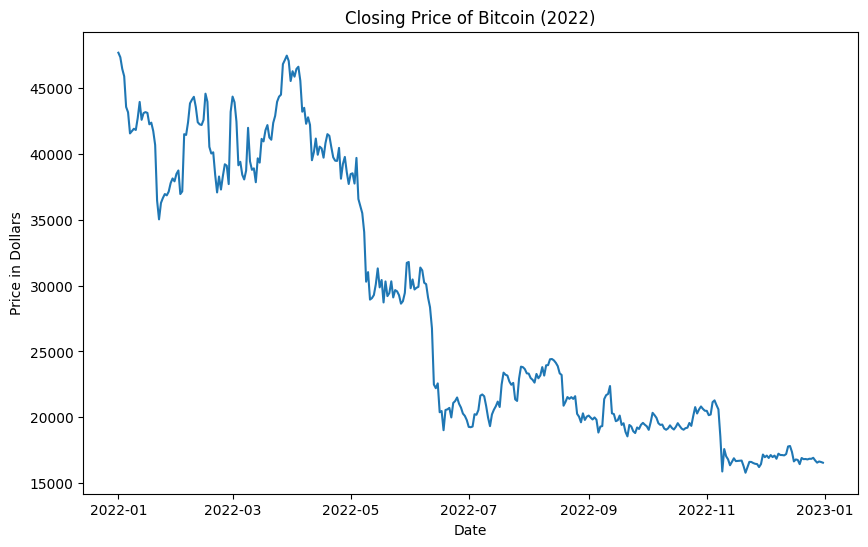

In [4]:
start_date = '2022-01-01'
end_date = '2022-12-31'
date_range = pd.date_range(start=start_date, end=end_date)

plt.figure(figsize=(10, 6))
plt.plot(date_range, ts)
plt.title('Closing Price of Bitcoin (2022)')
plt.xlabel('Date')
plt.ylabel('Price in Dollars')
plt.show()

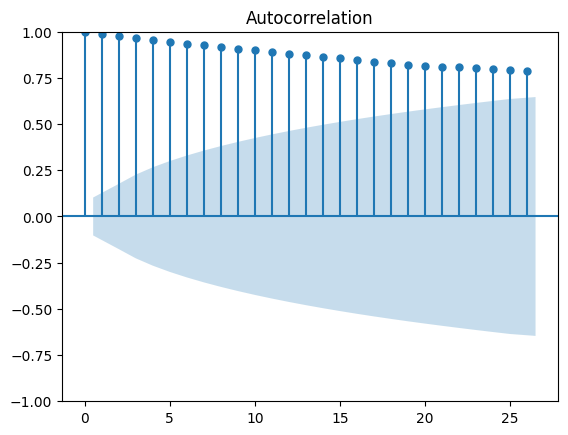

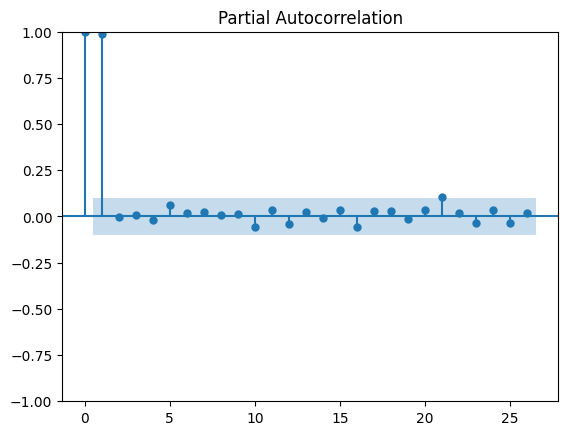

In [5]:
plot_acf(ts)
plt.show()

plot_pacf(ts)
plt.show()

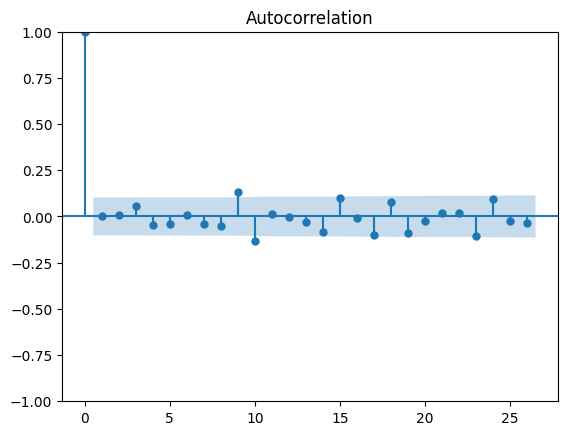

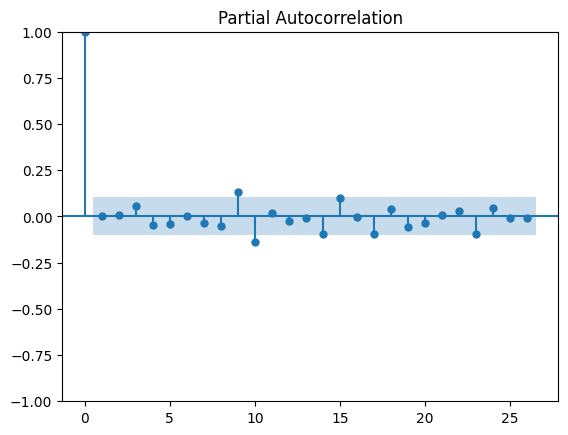

In [6]:
diff = np.diff(ts)

plot_acf(diff)
plt.show()

plot_pacf(diff)
plt.show()

In [7]:
unit_test = adfuller(diff)

#Print results
print('ADF Statistic: %f' % unit_test[0])
print('p-value: %f' % unit_test[1])
print('Critical Values:', unit_test[4])

if unit_test[1] <= 0.05:
    print(f'Reject the null hypothesis. The time-series is stationary.')
else: 
    print(f"Fail to reject the null hypothesis. The time-series is non-stationary")

ADF Statistic: -6.511663
p-value: 0.000000
Critical Values: {'1%': np.float64(-3.4489583388155194), '5%': np.float64(-2.869739378430086), '10%': np.float64(-2.5711381780459)}
Reject the null hypothesis. The time-series is stationary.


In [8]:
# train-validation-test split for time series
train_size = int(len(ts) * 0.60)
train, rest = ts[:train_size], ts[train_size:]

validation_size = int(len(rest) * 0.50)
validation, test = rest[:validation_size], rest[validation_size:]

print(len(train))
print(len(validation))
print(len(test))

219
73
73


In [9]:
def residual_diagnostics(residuals):

    residuals = pd.Series(residuals)

    print("Residual Diagnostics:\n")

    # 1. Test for the expected value of the residuals. We would expect them to be = 0
    t_stat, p_value = ttest_1samp(residuals,0)
    if p_value < 0.05:
        print('The mean of the residuals is statistically different from zero\n')
    else:
        print('The mean of the residuals is not statistically significant from zero\n')

    # 2. Test for linear and non-linear heteroscedasticity
    lags = sm.add_constant(
    pd.DataFrame({
        f"lag_{i}": residuals.shift(i) for i in range(1, 3)  # Using 2 lags as an example
    }).dropna())

    # Breusch-Pagan test
    bp_test = het_breuschpagan(residuals[lags.index], lags)
    bp_labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
    bp_results = dict(zip(bp_labels, bp_test))

    # White's test
    white_test = het_white(residuals[lags.index], lags)
    white_labels = ['Test Statistic', 'p-value', 'f-value', 'f p-value']
    white_results = dict(zip(white_labels, white_test))

    # Display results
    print("Breusch-Pagan Test:")
    for k, v in bp_results.items():
        print(f"{k}: {v:.4f}")

    print("\nWhite's Test:")
    for k, v in white_results.items():
        print(f"{k}: {v:.4f}")

    # 3. Test for residual serial correlation (Breusch-Godfrey test)
    X = sm.add_constant(np.arange(len(residuals)))
    reg_model = sm.OLS(residuals, X).fit()
    bg_test = acorr_breusch_godfrey(reg_model, nlags=4)
    if bg_test[1] < 0.05:
        print("\nSignificant autocorrelation detected in the residuals.")
    else:
        print("\nNo significant autocorrelation detected in the residuals.")
    
    # 4. Plot Residual Diagnostics
    plt.figure(figsize=(12, 8))
    
    # Plot ACF
    plt.subplot(2, 2, 1)
    plot_acf(residuals, lags=20, ax=plt.gca())
    plt.title("Autocorrelation Function (ACF)")
    
    # Plot PACF
    plt.subplot(2, 2, 2)
    plot_pacf(residuals, lags=20, ax=plt.gca(), method='ywm')
    plt.title("Partial Autocorrelation Function (PACF)")
    
    # Histogram of residuals
    plt.subplot(2, 2, 3)
    plt.hist(residuals, bins=15, edgecolor='k')
    plt.title("Histogram of Residuals")
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    
    # QQ Plot
    plt.subplot(2, 2, 4)
    pd.Series(residuals).plot(kind='kde')
    plt.title("Residual Density")
    
    plt.tight_layout()
    plt.show()

## Validation

In [10]:
def validiation_process(train_set, validation_set):
    '''
    Selects the most optimal model parameters based on RMSE on the validation set. 

    Input: training set, validation set
    Output: optimal p, optimal q, rmse, predictions
    '''

    #These are the values to be returned by this function
    best_p = None
    best_q = None
    lowest_rmse = float('inf')
    predictions = []

    #Run through each possible p and q in our selected range
    for p in range(0,7):
        for q in range(0,7):
            try:
                history = list(train_set)
                temp_predictions = [] 

                #Run through each valdiation set observation
                for i in range(len(validation_set)):
                    model = ARIMA(history, order=(p,1,q))
                    results = model.fit()
                    
                    #One-step-ahead forecast
                    yhat = results.forecast()
                    yhat = yhat[0]

                    #Append history with latest observation and update predictions with latest prediction
                    obs = validation_set[i]
                    history.append(obs)
                    temp_predictions.append(yhat)
                
                #Calculate RMSE for the predictions 
                valid_mse = mean_squared_error(validation_set, temp_predictions)
                valid_rmse = sqrt(valid_mse)
                print(f"Validation RMSE for ARIMA({p},1,{q}): {valid_rmse}")

                #Update optimal ARMA model based on RMSE and update its predictions
                if valid_rmse < lowest_rmse:
                    best_p = p
                    best_q = q
                    lowest_rmse = valid_rmse
                    predictions = temp_predictions
                    print(f"New best p and q: {best_p}, {best_q}")

            except Exception as e:
                print(f'Skipped ARIMA({p},1,{q}) due to: {e}')
            
    return best_p, best_q, lowest_rmse, predictions

best_p_valid, best_q_valid, valid_rmse, valid_predictions = validiation_process(train, validation)

Validation RMSE for ARIMA(0,1,0): 587.4598443015208
New best p and q: 0, 0
Validation RMSE for ARIMA(0,1,1): 587.2569938531639
New best p and q: 0, 1
Validation RMSE for ARIMA(0,1,2): 588.5588233868201
Validation RMSE for ARIMA(0,1,3): 588.9189854954594
Validation RMSE for ARIMA(0,1,4): 580.7227796635794
New best p and q: 0, 4
Validation RMSE for ARIMA(0,1,5): 581.516433225746
Validation RMSE for ARIMA(0,1,6): 577.1250231164845
New best p and q: 0, 6
Validation RMSE for ARIMA(1,1,0): 587.262320853366
Validation RMSE for ARIMA(1,1,1): 589.4367734189614
Validation RMSE for ARIMA(1,1,2): 578.9339578547056
Validation RMSE for ARIMA(1,1,3): 577.2960873513455
Validation RMSE for ARIMA(1,1,4): 573.5520750362351
New best p and q: 1, 4
Validation RMSE for ARIMA(1,1,5): 572.3611526970858
New best p and q: 1, 5
Validation RMSE for ARIMA(1,1,6): 571.7427743784847
New best p and q: 1, 6
Validation RMSE for ARIMA(2,1,0): 588.4057358544021
Validation RMSE for ARIMA(2,1,1): 581.2529614791599
Validatio

Optimal ARIMA Model: ARIMA(3,1,3)
Validation RMSE: 567.7878181690811


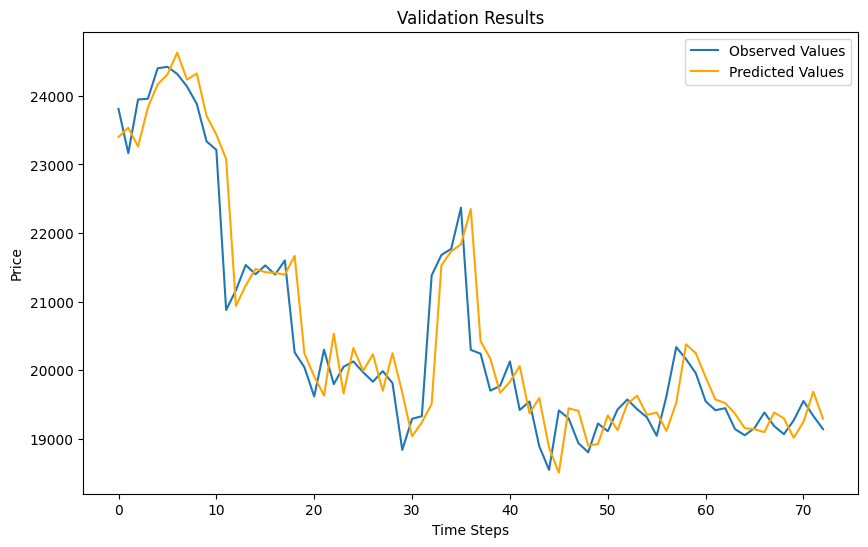

In [11]:
print(f'Optimal ARIMA Model: ARIMA({best_p_valid},1,{best_q_valid})')
print(f'Validation RMSE: {valid_rmse}')

plt.figure(figsize=(10, 6))
plt.plot(validation, label='Observed Values')
plt.plot(valid_predictions, c='orange', label="Predicted Values")
plt.title("Validation Results")
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.savefig('validation-results.png')
plt.show()

Residual Diagnostics:

The mean of the residuals is not statistically significant from zero

Breusch-Pagan Test:
Lagrange multiplier statistic: 0.6468
p-value: 0.7237
f-value: 0.3126
f p-value: 0.7326

White's Test:
Test Statistic: 1.4653
p-value: 0.9170
f-value: 0.2740
f p-value: 0.9258

No significant autocorrelation detected in the residuals.


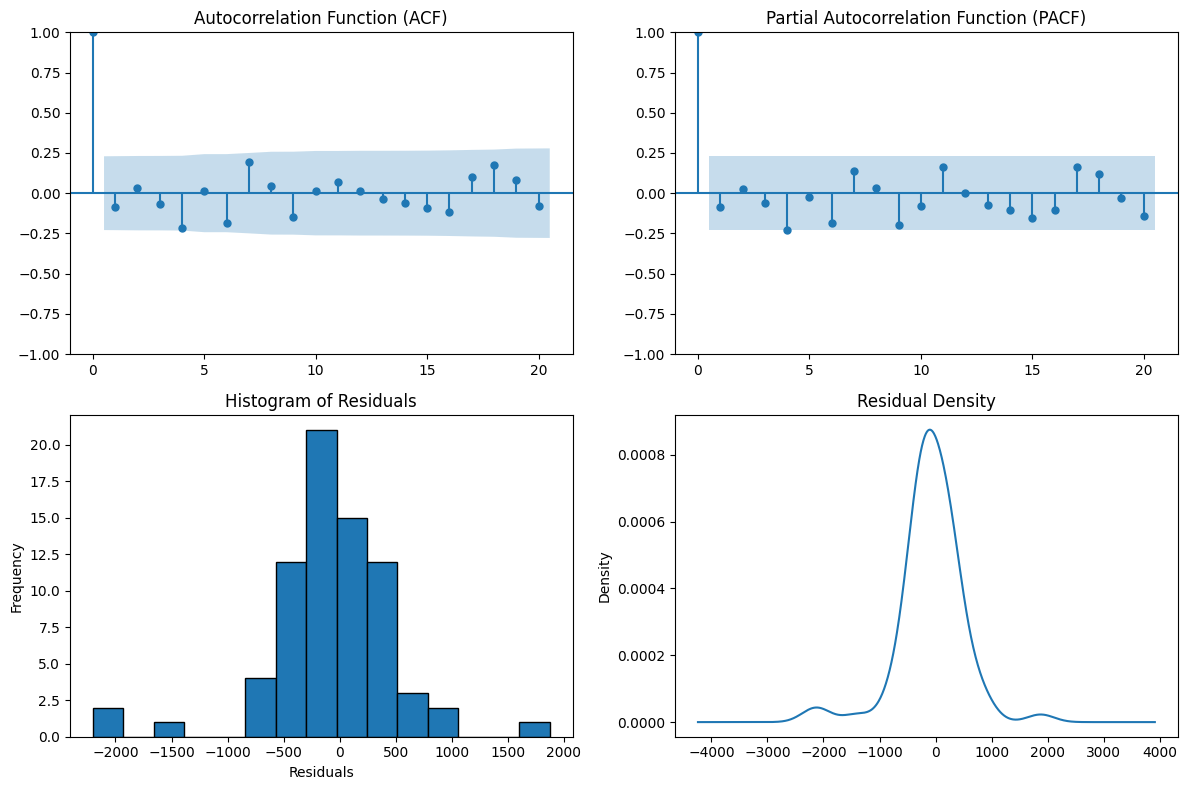

In [12]:
# plot residuals
residuals_valid = validation - valid_predictions
residual_diagnostics(residuals_valid)

## Training

In [13]:
model = ARIMA(train, order=(best_p_valid,1,best_q_valid))
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  219
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -1854.762
Date:                Thu, 12 Dec 2024   AIC                           3723.523
Time:                        16:17:14   BIC                           3747.215
Sample:                             0   HQIC                          3733.093
                                - 219                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9308      0.036    -26.086      0.000      -1.001      -0.861
ar.L2          0.9709      0.024     40.865      0.000       0.924       1.017
ar.L3          0.9154      0.034     27.242      0.0

Residual Diagnostics:

The mean of the residuals is not statistically significant from zero

Breusch-Pagan Test:
Lagrange multiplier statistic: 1.8756
p-value: 0.3915
f-value: 0.9329
f p-value: 0.3950

White's Test:
Test Statistic: 2.0303
p-value: 0.8449
f-value: 0.3985
f p-value: 0.8495

No significant autocorrelation detected in the residuals.


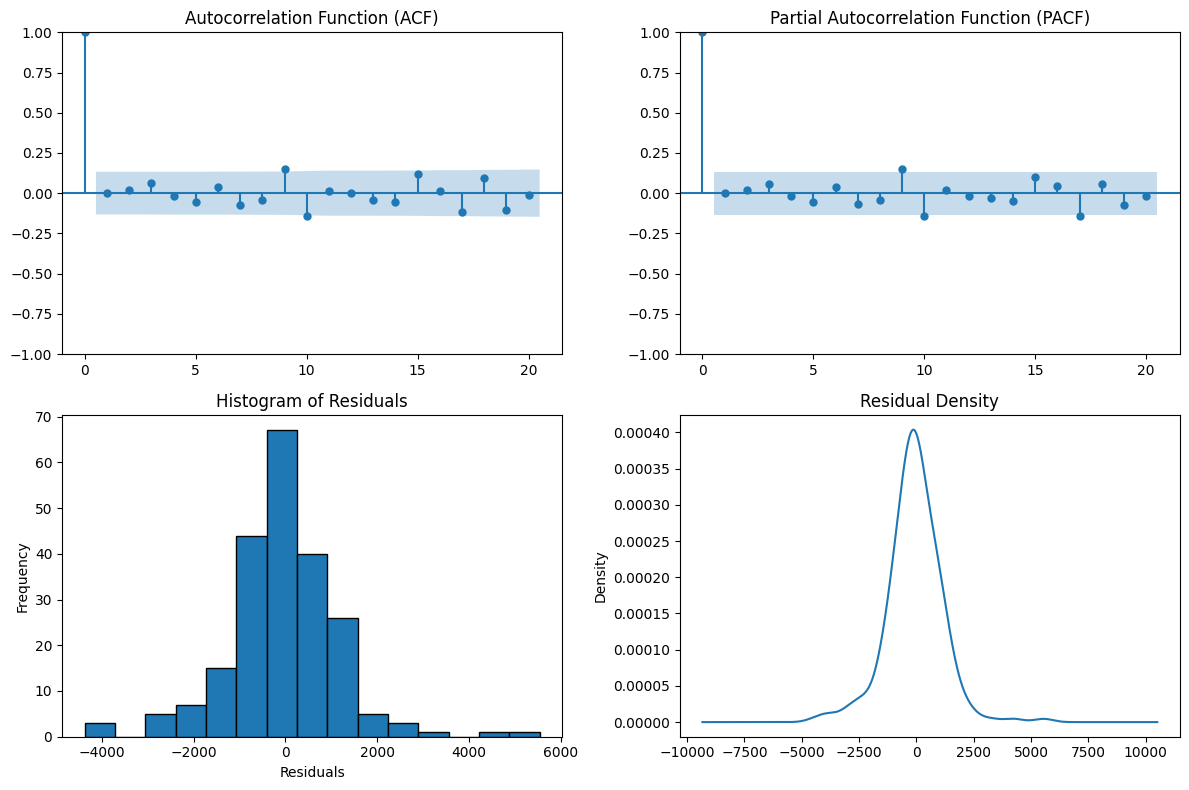

In [14]:
residuals_train = results.resid[1:]
residual_diagnostics(residuals_train)

Train RMSE: 1199.099581804767


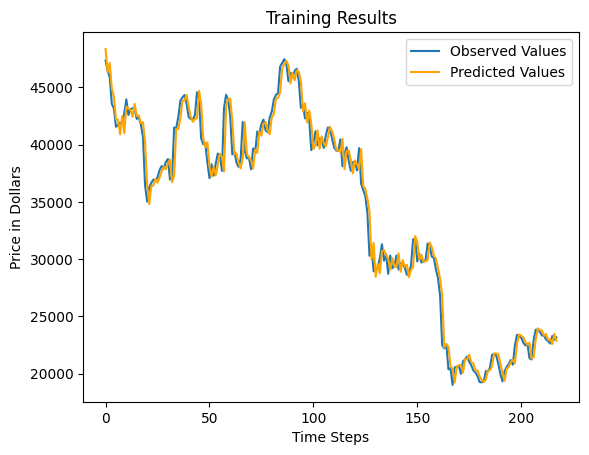

In [15]:
train_predictions = results.fittedvalues[1:] #remove the first value due to differencing in ARIMA

train_mse = mean_squared_error(train[1:], train_predictions)
train_rmse = sqrt(train_mse)
print(f"Train RMSE: {train_rmse}")


plt.plot(train[1:], label='Observed Values')
plt.plot(train_predictions, c='orange', label="Predicted Values")
plt.title("Training Results")
plt.xlabel('Time Steps')
plt.ylabel('Price in Dollars')
plt.legend()
plt.savefig('training-results.png')
plt.show()

## Testing

Test RMSE: 17830.361061633936


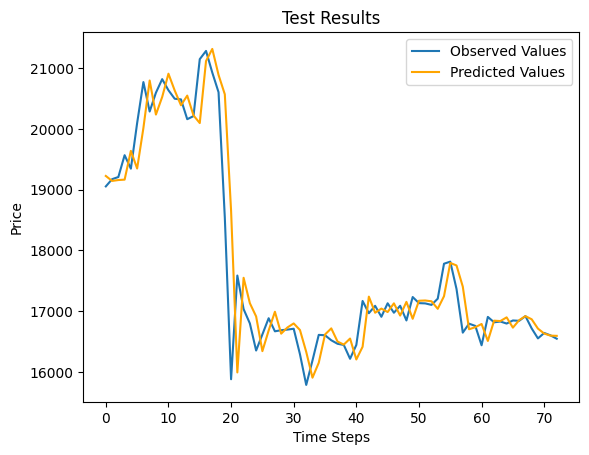

In [16]:
def testing_process(training_set, validation_set, testing_set, p, q):
    '''
    Makes out-of-sample predictions on the testing set.

    Input: train, validation, and testing set, optimal p and q based on validation testing
    Output: predictions, rmse
    '''

    history = list(training_set) + list(validation_set)
    predictions = []

    #Prediction
    for i in range(len(testing_set)):
        model = ARIMA(history, order=(p,1,q))
        results = model.fit()
        
        #One-step-ahead forecast
        yhat = results.forecast()
        yhat = yhat[0]

        #Append history with latest observation and update predictions with latest prediction
        obs = testing_set[i]
        history.append(obs)
        predictions.append(yhat)
    
    #Calculate RMSE
    mse = mean_squared_error(np.log(testing_set), predictions)
    rmse = sqrt(mse)
            
    return predictions, rmse

test_predictions, test_rmse = testing_process(train, validation, test, best_p_valid, best_q_valid)

print(f'Test RMSE: {test_rmse}')

plt.plot(test, label='Observed Values')
plt.plot(test_predictions, c='orange', label="Predicted Values")
plt.title("Test Results")
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.savefig('testing-results.png')
plt.show()

Residual Diagnostics:

The mean of the residuals is not statistically significant from zero

Breusch-Pagan Test:
Lagrange multiplier statistic: 22.7425
p-value: 0.0000
f-value: 16.0233
f p-value: 0.0000

White's Test:
Test Statistic: 46.8510
p-value: 0.0000
f-value: 25.2210
f p-value: 0.0000

No significant autocorrelation detected in the residuals.


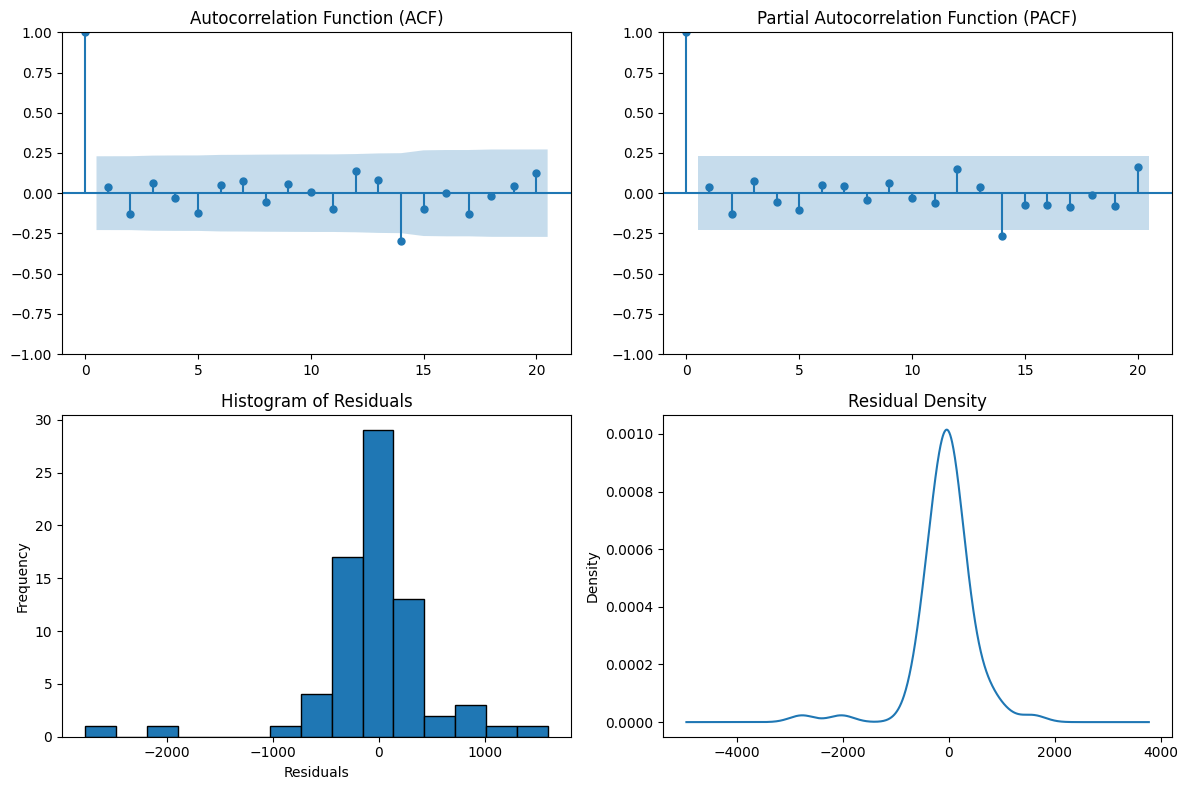

In [17]:
# plot residuals
residuals_test = test - test_predictions
residual_diagnostics(residuals_test)

Inspecting the variance in the residuals of the test set

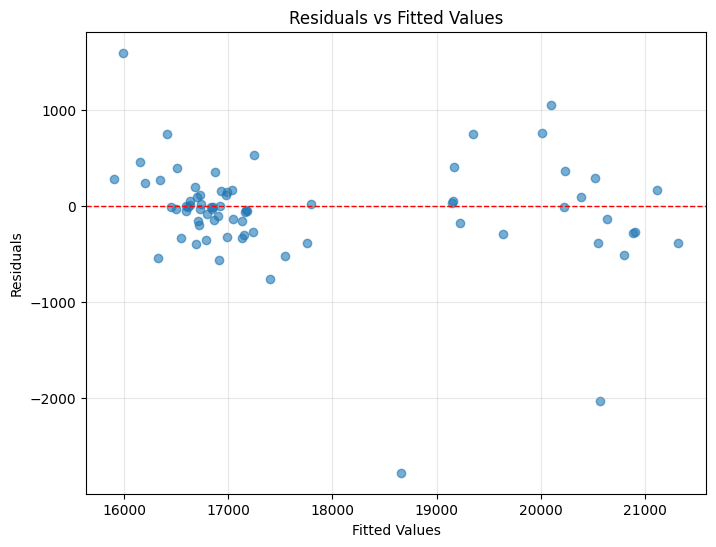

In [18]:
# Plotting test predictions against the residuals
plt.figure(figsize=(8, 6))
plt.scatter(test_predictions, residuals_test, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--', linewidth=1)
plt.title("Residuals vs Fitted Values")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.grid(alpha=0.3)
plt.savefig('residual-vs-fitted-test.png')
plt.show()

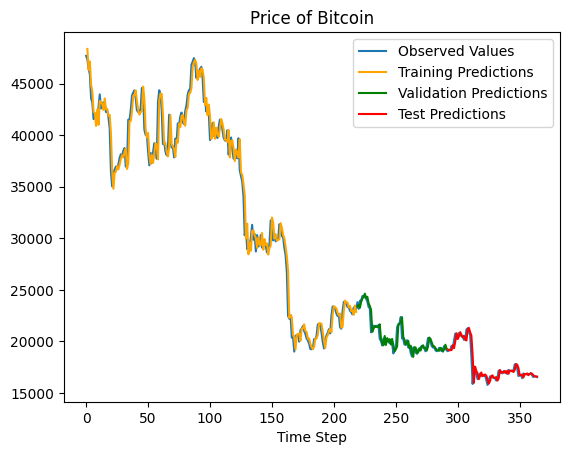

train RMSE 1199.0996, validation RMSE 567.7878, test RMSE 17830.3611


In [19]:
train_plot = np.ones_like(ts) * np.nan
train_plot[1:train_size] = train_predictions

valid_plot = np.ones_like(ts) * np.nan
valid_plot[train_size:train_size+validation_size] = valid_predictions

test_plot = np.ones_like(ts) * np.nan
test_plot[train_size+validation_size:] = test_predictions

# plot
plt.plot(ts, label='Observed Values')
plt.plot(train_plot, c='orange', label="Training Predictions")
plt.plot(valid_plot, c='green', label='Validation Predictions')
plt.plot(test_plot, c='r', label='Test Predictions')
plt.xlabel('Time Step')
plt.title('Price of Bitcoin')
plt.legend()
plt.savefig('all-predictions-plot.png')
plt.show()

print(f"train RMSE {train_rmse:.4f}, validation RMSE {valid_rmse:.4f}, test RMSE {test_rmse:.4f}")